<table><tr><td>This work sponsored by <a href="https://www.nsf.gov/awardsearch/showAward?AWD_ID=1550551">NSF grant 1550551</a></td><td><img src="https://www.nsf.gov/awardsearch/images/common/nsf_logo_bottom.png"></td></tr></table>

# Hyperbolic PDEs

Most formulations of the Einstein equations for the spacetime (with $c=1$) look roughly like *wave equations*

$$
\frac{\partial^2 \phi}{\partial t^2} = \nabla^2 \phi.
$$

We will focus on the simple $1+1$d case

$$
\frac{\partial^2 \phi}{\partial t^2} = \frac{\partial^2 \phi}{\partial x^2}.
$$

For numerical evolution we either write this as first order in time,

$$
\frac{\partial}{\partial t} \begin{pmatrix} \phi \\ \phi_t \end{pmatrix} = \begin{pmatrix} \phi_t \\ 0 \end{pmatrix} + \frac{\partial^2}{\partial x^2} \begin{pmatrix} 0 \\ \phi \end{pmatrix},
$$

or as first order in time *and* space

$$
\frac{\partial}{\partial t} \begin{pmatrix} \phi \\ \phi_t \\ \phi_x \end{pmatrix} = \begin{pmatrix} \phi_t \\ 0 \\ 0 \end{pmatrix} + \frac{\partial}{\partial x} \begin{pmatrix} 0 \\ \phi_x \\ \phi_t \end{pmatrix}.
$$

We will first focus on the first order form, written as

$$
\partial_t {\bf u} = {\bf s} + \partial_x {\bf f}({\bf u}).
$$

## Method of Lines

We have already used our finite difference approximations to replace partial derivatives (usually in space) with discrete approximations. We could use finite difference approximations directly here, replacing both time and space derivatives. However, an alternative approach is standard in Numerical Relativity.

First we put down a grid *in space* $\{ x_i \}$ for which we have values $\{ {\bf u}_i \}$. All these values can be thought of as one large vector ${\bf U}$. Now, on this grid we can use our finite difference approximation to replace the partial derivatives in space, which we write in discrete operator form as

$$
  \partial_x {\bf f}({\bf u}) \to L({\bf U}).
$$

The operator takes the discrete values $\{ {\bf u}_i \}$ and combines them, using the finite differencing formulas, to approximate the partial derivative required.

This means we have converted the original *partial* differential equation to the system of *ordinary* differential equation

$$
  \frac{d}{d t} {\bf U} = {\bf s}({\bf U}) + L({\bf U}) = {\bf F}({\bf U}).
$$

We can then solve this ODE as an initial value problem by specifying
the state of the system ${\bf U}$ at some time $t_0$ and evolve forward in time.

### (Dis)advantages

The Method of Lines (MoL) allows for minimally-coupled physical systems, such as GRMHD, to be split up into multiple pieces, which can be more easily tested, with a broader variety of numerical methods applied, and more straightforwardly have their stability checked.

However, it is typical that numerical methods that use MoL cannot easily take advantage of all the physical information in the system, may require smaller timesteps, may be less efficient, and may have less accuracy. Before worrying about this too much, check whether your time (in implementing a more efficient method) is worth less than the computer's (which will do the extra computation).

### Runge-Kutta methods

When looking at central differencing earlier we used information from both sides of the point where we took the derivative. This gives higher accuracy, but isn't helpful in the initial value case, where we don't have half the information.

The simplest approach is to use the forward Euler method

$$
  {\bf U}^{(i+1)} = {\bf U}^{(i)} + \Delta t \,{\bf F}\left ({\bf U}^{(i)}\right ).
$$

However, this is very inaccurate. Fortunately, higher order methods can be constructed with multiple Euler steps as building blocks. Each one gives an approximation to "future" data, which can be used to approximate the derivative at more locations.

For example, the Euler step above starts from ${\bf U}^{(i)}$ and computes ${\bf F}\left ({\bf U}^{(i)}\right )$ to approximate ${\bf U}^{(i+1)}$. We can use this approximation to give us ${\bf F}\left ({\bf U}^{(i+1)}\right)$.

Now, a more accurate solution would be

$$
  {\bf U}^{(i+1)} = {\bf U}^{(i)} + \int_{t_i}^{t_{i+1}} \text{d} t \,F\left ({\bf U}^{(i)}\right ).
$$

In Euler's method we are effectively representing the value of the integral by the value of the integrand at the start, multiplied by the width $\Delta t$. We could now approximate it by the *average* value of the integrand, $\left ({\bf F}^{(i)} + {\bf F}^{(i+1)}\right )/2$, multiplied by the width $\Delta t$. This gives the algorithm

\begin{align}
  {\bf U}^{(p)} &= {\bf U}^{(i)} + \Delta t\, {\bf F}\left ({\bf U}^{(i)}\right ), \\
  {\bf U}^{(i+1)} &= {\bf U}^{(i)} + \frac{\Delta t}{2} \left( {\bf F}\left ({\bf U}^{(i)}\right ) + {\bf F}\left ({\bf U}^{(p)}\right ) \right) \\
  &= \frac{1}{2} \left( {\bf U}^{(i)} + {\bf U}^{(p)} + \Delta t \, {\bf F}\left({\bf U}^{(p)}\right ) \right).
\end{align}

The final re-arrangement ensures we do not have to store or re-compute ${\bf F}^{(i)}$. This is one of the *Runge-Kutta* methods. This version is second order accurate, and a big improvement over Euler's method.

# Implementation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

We start by implementing the right-hand-side of the evolution: the source term, and the term corresponding to the partial derivative in space:

In [2]:
def RHS(U, dx):
    """
    RHS term.
    
    Parameters
    ----------
    
    U : array
        contains [phi, phi_t, phi_x] at each point
    dx : double
        grid spacing
        
    Returns
    -------
    
    dUdt : array
        contains the required time derivatives
    """
    
    phi = U[0,:]
    phi_t = U[1,:]
    phi_x = U[2,:]
    
    dUdt = np.zeros_like(U)
    
    dUdt[0,:] = phi_t 
        #(d/dt)[phi] = phi_t
        #NOTE: defined at all grid points, including boundaries
    
    dUdt[1,1:-1] = 1.0/(2.*dx)*(phi_x[2:] - phi_x[:-2]) 
        #(d/dt)[phi_t] = (d/dt)^2[phi] = (d/dx)^2[phi] = (d/dx)[phi_x]
        #NOTE: not defined at boundary points (first and last grid points)
    
    dUdt[2,1:-1] = 1.0/(2.*dx)*(phi_t[2:] - phi_t[:-2])
        #(d/dt)[phi_x] = (d/dt)(d/dx)[phi] = (d/dx)(d/dt)[phi] = (d/dx)[phi_t]
        #NOTE: not defined at boundary points (first and last grid points)

    return dUdt

We see that this doesn't give us the update term at the edges of the domain. We'll enforce that the domain is *periodic* as a simple boundary condition. Usually this would be an outgoing wave type boundary condition, but anything that fixes the update term at the boundary is fine.

In [3]:
def apply_boundaries(dUdt):
    """
    Periodic boundaries
    """
    #Recall: first and last grid points need to be assigned
    dUdt[:,0] = dUdt[:,-2] #first grid point --> second-to-last grid point
    dUdt[:,-1] = dUdt[:,1] #last grid point --> second grid point
    
    return dUdt

Then we fix the grid. To work with the periodic domain we need to stagger the grid away from the boundaries. We'll fix the domain to be $x \in [-1, 1]$:

In [4]:
def grid(Npoints):
    """
    Npoints is the number of interior points
    """
    xmin = -1.0 #left domain boundary
    xmax = 1.0 #right domain boundary
    
    dx = (xmax - xmin)/Npoints #grid spacing

    # We're using a cell-centered grid:
    # - left boundary lies between first and second grid points
    # - right boundary lies between last and second-to-last grid points
    x_i_min = xmin - dx/2.0 
        #leftmost grid point, staggered half-step to left of boundary
    x_i_max = xmax + dx/2.0 
        #rightmost grid point, staggered half-step to right of boundary

    return dx, np.linspace(x_i_min, x_i_max, Npoints+2)

We take the RK2 method from earlier. This will take only one step but requires two RHS evaluations.

In [5]:
def RK2_step(U, RHS, apply_boundaries, dt, dx):
    """
    RK2 method
    """
    
    rhs = RHS(U, dx)
    rhs = apply_boundaries(rhs)
    
    U_p = U + dt*rhs
    
    rhs_p = RHS(U_p, dx)
    rhs_p = apply_boundaries(rhs_p)
    
    U_new = 0.5*(U + U_p + dt*rhs_p)
    
    return U_new

There are only two things we need to fix. One is the timestep. For now, we'll set it to $\Delta t = \Delta x / 4$. The second is the initial data. We will choose the initial data to be a time symmetric gaussian,

$$
\phi(0, x) = \exp \left( -20 x^2 \right), \qquad \partial_t \phi (0, x) = 0,
$$

which implies

$$
\partial_x \phi(0, x) = -40 x \exp \left( -20 x^2 \right).
$$

In [6]:
def initial_data(x):
    """
    Set the initial data. x are the coordinates. U (phi, phi_t, phi_x) are the variables.
    """
    
    U = np.zeros((3, len(x)))
    U[0, :] = np.exp(-20.0 * x**2)
    U[2, :] = -40.0*x*np.exp(-20.0 * x**2)
    
    return U

Now we can evolve:

In [7]:
Npoints = 50
dx, x = grid(Npoints)
dt = dx/4
U0 = initial_data(x)
U = initial_data(x)
tFinal = 1.0
Nsteps = int(tFinal/dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt , dx)

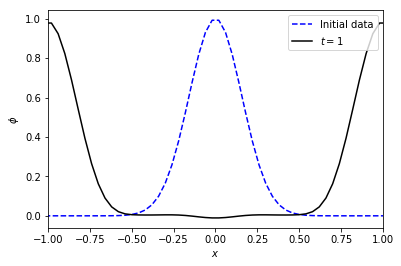

In [8]:
plt.figure()
plt.plot(x, U0[0, :], 'b--', label="Initial data")
plt.plot(x, U[0, :], 'k-', label=r"$t=1$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi$")
plt.xlim(-1, 1)
plt.legend()
plt.show()

We can see the expected behaviour: the initial data splits into two pulses that propagate in opposite directions. With periodic boundary conditions, we can evolve to $t=2$ and we should get the initial data back again:

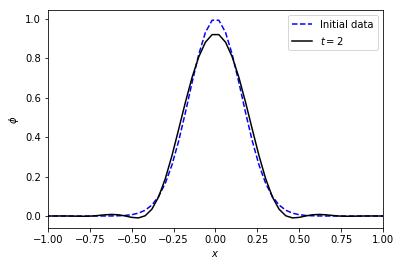

In [9]:
Npoints = 50
dx, x = grid(Npoints)
dt = dx/4
U0 = initial_data(x)
U = initial_data(x)
tFinal = 2.0
Nsteps = int(tFinal/dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
plt.figure()
plt.plot(x, U0[0, :], 'b--', label="Initial data")
plt.plot(x, U[0, :], 'k-', label=r"$t=2$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi$")
plt.xlim(-1, 1)
plt.legend()
plt.show()

### Animations

In [17]:
from matplotlib import animation
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

In [11]:
Npoints = 50
dx, x = grid(Npoints)
dt = dx/4
U0 = initial_data(x)
U = initial_data(x)
tFinal = 3.0
Nsteps = int(tFinal/dt)
Uframes = np.zeros((Nsteps+1,3,Npoints+2))
Uframes[0,:,:] = U0
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    Uframes[n+1,:,:] = U
    
fig = plt.figure(figsize=(8,5))
ax = plt.axes(xlim=(-1,1),ylim=(-0.2, 1.2))
line, = ax.plot([], [])
plt.close()

def init():
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\phi$")

def update(i):
    line.set_data(x, Uframes[i, 0, :])
    return line

animation.FuncAnimation(fig, update, init_func=init, frames=Nsteps, interval=100, blit=True)

Traceback (most recent call last):
  File "/home/ejwest/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/ejwest/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/home/ejwest/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1746, in _init_draw
    raise RuntimeError('The init_func must return a '
RuntimeError: The init_func must return a sequence of Artist objects.


RuntimeError: The init_func must return a sequence of Artist objects.

### Convergence

We can now simply check convergence, by taking the norm of the difference between the initial solution and the solution at $t=2$:

In [12]:
def error_norms(U, U_initial):
    """
    Error norms (1, 2, infinity)
    """
    
    N = len(U)
    L1 = np.sum(np.abs(U - U_initial))/N
    L2 = np.sqrt(np.sum((U - U_initial)**2)/N)
    LInf = np.max(np.abs(U - U_initial))
    
    return L1, L2, LInf

In [13]:
Npoints_all = 50 * 2**(np.arange(0, 6))

dxs = np.zeros((len(Npoints_all,)))
wave_errors = np.zeros((3, len(Npoints_all)))

for i, Npoints in enumerate(Npoints_all):
    dx, x = grid(Npoints)
    dt = dx / 4
    U0 = initial_data(x)
    U = initial_data(x)
    tFinal = 2.0
    Nsteps = int(tFinal / dt)
    for n in range(Nsteps):
        U = RK2_step(U, RHS, apply_boundaries, dt, dx)

    dxs[i] = dx
    wave_errors[:, i] = error_norms(U[0, :], U0[0, :])

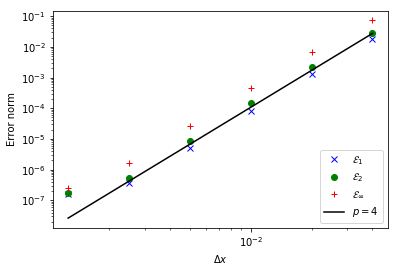

In [14]:
plt.figure()
plt.loglog(dxs, wave_errors[0, :], 'bx', label=r"${\cal E}_1$")
plt.loglog(dxs, wave_errors[1, :], 'go', label=r"${\cal E}_2$")
plt.loglog(dxs, wave_errors[2, :], 'r+', label=r"${\cal E}_{\infty}$")
plt.loglog(dxs, wave_errors[1, 0]*(dxs/dxs[0])**4, 'k-', label=r"$p=4$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("Error norm")
plt.legend(loc="lower right")
plt.show()

This fourth order convergence is an artefact of the initial data and boundary conditions, which are perfectly symmetric. If we change the initial data to make it asymmetric, we'll get something much closer to second order:

In [15]:
def initial_data_asymmetric(x):
    """
    Set the initial data. x are the coordinates. U (phi, phi_t, phi_x) are the variables.
    """
    
    U = np.zeros((3, len(x)))
    U[0, :] = np.sin(np.pi*x)*(1-x)**2*(1+x)**3
    U[2, :] = np.pi*np.cos(np.pi*x)*(1-x)**2*(1+x)**3 + np.sin(np.pi*x)*(2.0*(1-x)*(1+x)**3 + 3.0*(1-x)**2*(1+x)**2)
    
    return U

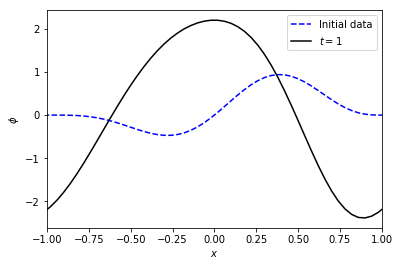

In [16]:
Npoints = 50
dx, x = grid(Npoints)
dt = dx/4
U0 = initial_data_asymmetric(x)
U = initial_data_asymmetric(x)
tFinal = 1.0
Nsteps = int(tFinal/dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
plt.figure()
plt.plot(x, U0[0, :], 'b--', label="Initial data")
plt.plot(x, U[0, :], 'k-', label=r"$t=1$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi$")
plt.xlim(-1, 1)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


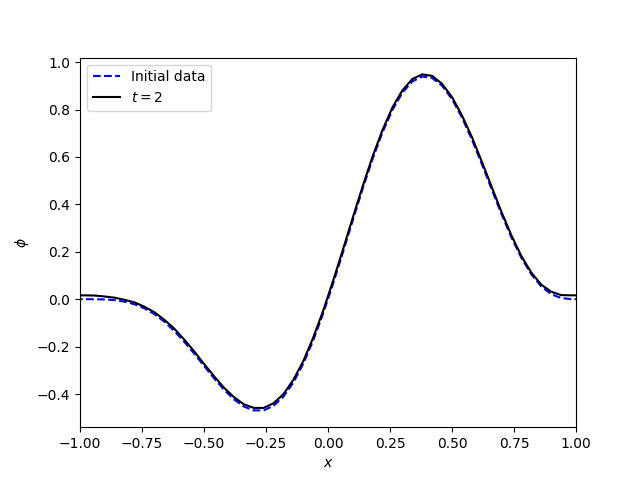

In [59]:
Npoints = 50
dx, x = grid(Npoints)
dt = dx/4
U0 = initial_data_asymmetric(x)
U = initial_data_asymmetric(x)
tFinal = 2.0
Nsteps = int(tFinal/dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
plt.figure()
plt.plot(x, U0[0, :], 'b--', label="Initial data")
plt.plot(x, U[0, :], 'k-', label=r"$t=2$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi$")
plt.xlim(-1, 1)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


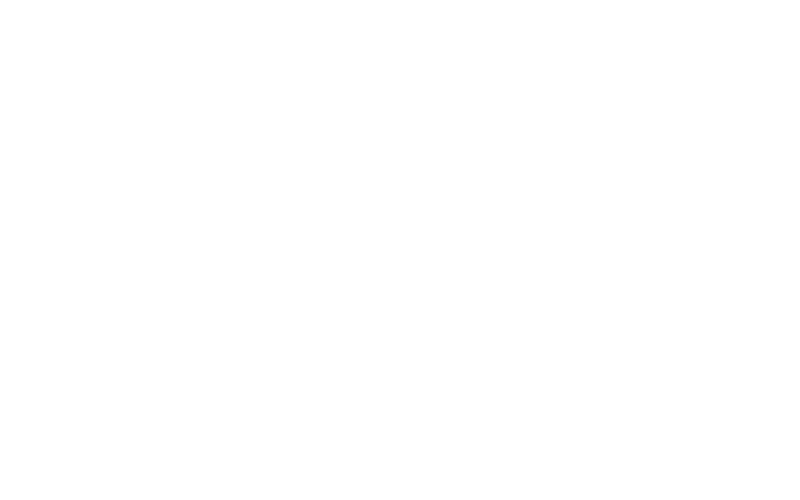

In [62]:
Npoints = 50
dx, x = grid(Npoints)
dt = dx/4
U0 = initial_data_asymmetric(x)
U = initial_data_asymmetric(x)
tFinal = 4.0
Nsteps = int(tFinal/dt)
Uframes = np.zeros((Nsteps+1,3,Npoints+2))
Uframes[0,:,:] = U0
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    Uframes[n+1,:,:] = U
    
fig = plt.figure(figsize=(8,5))
ax = plt.axes(xlim=(-1,1),ylim=(-3, 3))
line, = ax.plot([], [])
plt.close()

def init():
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\phi$")

def update(i):
    line.set_data(x, Uframes[i, 0, :])
    return line

animation.FuncAnimation(fig, update, init_func=init, frames=Nsteps, interval=100, blit=True)

In [63]:
Npoints_all = 50 * 2**(np.arange(0, 6))

dxs = np.zeros((len(Npoints_all,)))
wave_errors = np.zeros((3, len(Npoints_all)))

for i, Npoints in enumerate(Npoints_all):
    dx, x = grid(Npoints)
    dt = dx/4
    U0 = initial_data_asymmetric(x)
    U = initial_data_asymmetric(x)
    tFinal = 2.0
    Nsteps = int(tFinal/dt)
    for n in range(Nsteps):
        U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
    dxs[i] = dx
    wave_errors[:, i] = error_norms(U[0, :], U0[0, :])

<IPython.core.display.Javascript object>


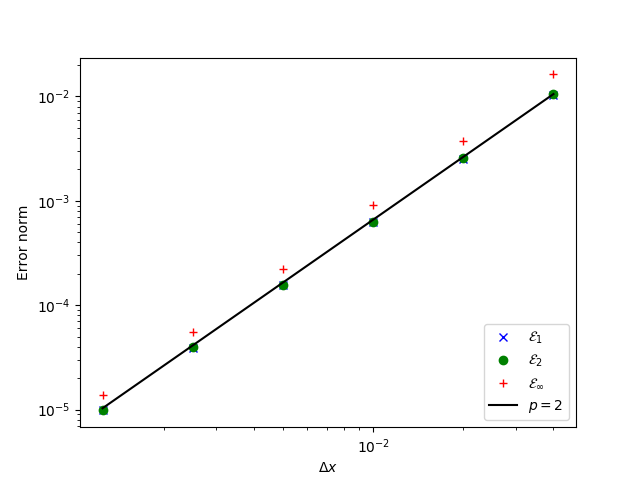

In [64]:
plt.figure()
plt.loglog(dxs, wave_errors[0, :], 'bx', label=r"${\cal E}_1$")
plt.loglog(dxs, wave_errors[1, :], 'go', label=r"${\cal E}_2$")
plt.loglog(dxs, wave_errors[2, :], 'r+', label=r"${\cal E}_{\infty}$")
plt.loglog(dxs, wave_errors[1, 0]*(dxs/dxs[0])**2, 'k-', label=r"$p=2$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("Error norm")
plt.legend(loc="lower right")
plt.show()

## Courant limits

We restricted the timestep to $\Delta t = \sigma \Delta x$ with $\sigma$, the *Courant number*, being $1/4$. As the number of timesteps we take is inversely related to the Courant number, we want to make it as large as possible. 

Let's try the evolution with Courant number $\sigma=1$:

<IPython.core.display.Javascript object>


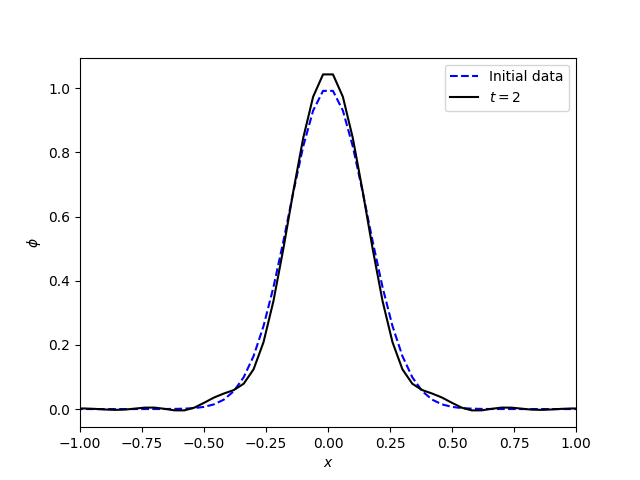

In [66]:
Npoints = 50
dx, x = grid(Npoints)
courant = 1.0
dt = courant*dx
U0 = initial_data(x)
U = initial_data(x)
tFinal = 2.0
Nsteps = int(tFinal/dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
plt.figure()
plt.plot(x, U0[0, :], 'b--', label="Initial data")
plt.plot(x, U[0, :], 'k-', label=r"$t=2$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi$")
plt.xlim(-1, 1)
plt.legend()
plt.show()

The result doesn't look too bad, but the numerical approximation is actually *bigger* than the correct solution. What happens as we increase resolution?

<IPython.core.display.Javascript object>


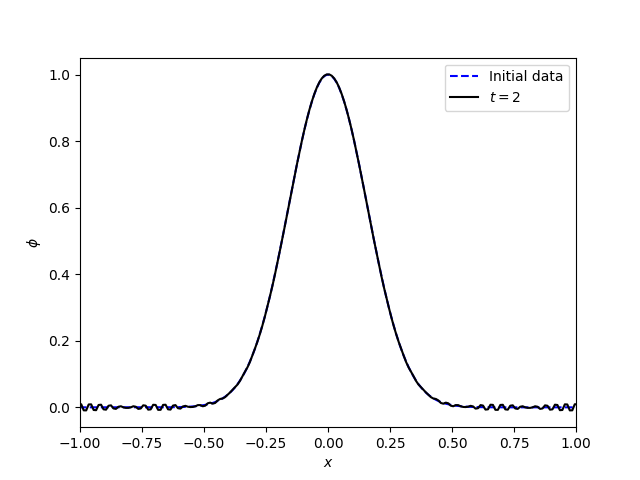

In [67]:
Npoints = 200
dx, x = grid(Npoints)
courant = 1.0
dt = courant*dx
U0 = initial_data(x)
U = initial_data(x)
tFinal = 2.0 
Nsteps = int(tFinal/dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
plt.figure()
plt.plot(x, U0[0, :], 'b--', label="Initial data")
plt.plot(x, U[0, :], 'k-', label=r"$t=2$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi$")
plt.xlim(-1, 1)
plt.legend()
plt.show()

The bulk of the solution looks good, but there's small oscillations at the edges. Increase resolution a bit further:

<IPython.core.display.Javascript object>


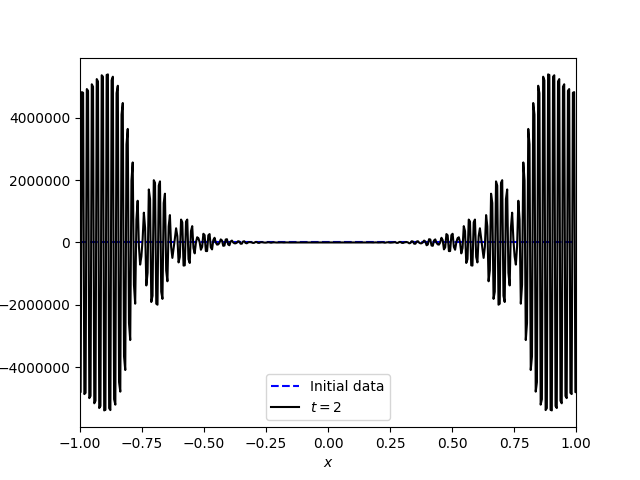

In [68]:
Npoints = 400
dx, x = grid(Npoints)
courant = 1.0
dt = courant*dx
U0 = initial_data(x)
U = initial_data(x)
tFinal = 2.0 
Nsteps = int(tFinal/dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
plt.figure()
plt.plot(x, U0[0, :], 'b--', label="Initial data")
plt.plot(x, U[0, :], 'k-', label=r"$t=2$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\phi$")
plt.xlim(-1, 1)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


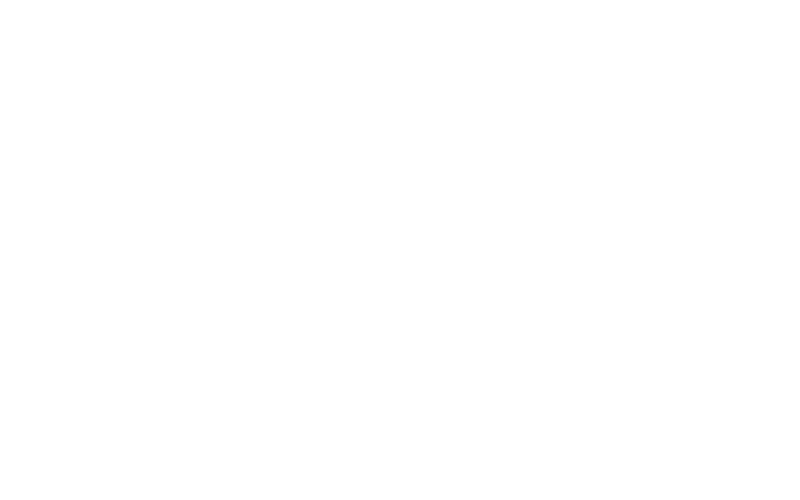

In [72]:
Npoints = 400
dx, x = grid(Npoints)
courant = 1.0
dt = courant*dx
U0 = initial_data(x)
U = initial_data(x)
tFinal = 2.0
Nsteps = int(tFinal/dt)
Uframes = np.zeros((Nsteps+1,3,Npoints+2))
Uframes[0,:,:] = U0
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    Uframes[n+1,:,:] = U
    
fig = plt.figure(figsize=(8,5))
ax = plt.axes(xlim=(-1,1),ylim=(-3, 3))
line, = ax.plot([], [])
plt.close()

def init():
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\phi$")

def update(i):
    line.set_data(x, Uframes[i, 0, :])
    return line

animation.FuncAnimation(fig, update, init_func=init, frames=Nsteps, interval=100, blit=True)

The result has blown up. We won't be seeing any convergence in this case.

For hyperbolic PDEs there is a Courant *limit*: a maximum timestep that is consistent with stability. This depends on the physics and the numerical method chosen. Typically a maximum limit is

$$
  \sigma < \frac{1}{\sqrt{D} \lambda_{\text{max}}}
$$

where $D$ is the number of spatial dimensions and $\lambda_{\text{max}}$ the maximum speed of information propagation (ie, the speed of light).

# Extension exercises

##### Second order in space

Implement a MoL solution to the wave equation using the second order in space form

$$
\frac{\partial}{\partial t} \begin{pmatrix} \phi \\ \phi_t \end{pmatrix} = \begin{pmatrix} \phi_t \\ 0 \end{pmatrix} + \frac{\partial^2}{\partial x^2} \begin{pmatrix} 0 \\ \phi \end{pmatrix}.
$$

This is more closely related to the BSSNOK formulation. Check convergence on the cases above. Compare the accuracy and efficiency of the approaches.

##### Fourth order differencing

Implement fourth order spatial differencing. You will need to change the boundary conditions - think how this should be done. Compare the results, and check the convergence rate. Should you expect fourth order convergence?

##### Third order in time

If you find that the method for time integration is a limitation, try implementing the third order Runge-Kutta method

\begin{align}
  {\bf U}^{(p_1)} &= {\bf U}^{(n)} + \Delta t \, {\bf F} \left( {\bf U}^{(n)}, t^n \right), \\
  {\bf U}^{(p_2)} &= \frac{1}{4} \left( 3 {\bf U}^{(n)} + {\bf U}^{(p_1)} + \Delta t \, {\bf F} \left( {\bf U}^{(p_1)}, t^{n+1} \right) \right), \\
  {\bf U}^{(n+1)} &= \frac{1}{3} \left( {\bf U}^{(n)} + 2 {\bf U}^{(p_2)} + 2 \Delta t \, {\bf F} \left( {\bf U}^{(p_2)}, t^{n+1} \right) \right).
\end{align}

Compare with both second and fourth order central spatial differencing.

##### This material is a slight modification of Ian Hawke's material for the 2016 Einstein Toolkit school in Trento, Italy.